In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, mutual_info_classif, SelectPercentile
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from pathlib import Path

import shap
shap.initjs()

RANDOM_STATE = 42

In [32]:
# # 1. Carrega de dades
BASE_DIR = Path('/usr/local/src/BlockSci/Notebooks/Ransomware - Mario i Albert/TFGA/')
RES_DIR = BASE_DIR / 'illicit' / "3000-1000-1000 all over tx 3 hops 3 random node limit" / "train" / "res_pipeline"
RADIUS = 6

# %%
df = pd.read_csv(RES_DIR / f"full_dataset_{RADIUS}_1:3.csv")
#print(df.describe())

# %% [markdown]
# ## 1.1 Separació de features i label

# %%
y = df['label'].astype(int).values
X = df.drop(columns=['btc_address', 'label', "pagerank", "betweenness", "eccentricity", "clustering"])
feature_names = X.columns.tolist()

In [ ]:
y = np.arange(len(df_stats))
offset = 0.15  # desplaçament vertical

fig, ax = plt.subplots(figsize=(8, 6))
# Lícit: desplaçar cap amunt
ax.errorbar(df_stats['Lícit Mitjana'], y + offset,
            xerr=df_stats['Lícit SD'], fmt='o', label='Lícit',
            capsize=3)
# Il·lícit: desplaçar cap avall
ax.errorbar(df_stats['Il·lícit Mitjana'], y - offset,
            xerr=df_stats['Il·lícit SD'], fmt='s', label='Il·lícit',
            capsize=3)

ax.set_yticks(y)
ax.set_yticklabels(df_stats['Variable'])
ax.set_xlabel('Mitjana ± SD')
ax.set_title(f'Comparació de variables per classe radi {RADIUS}')
ax.legend()
plt.tight_layout()
plt.show()

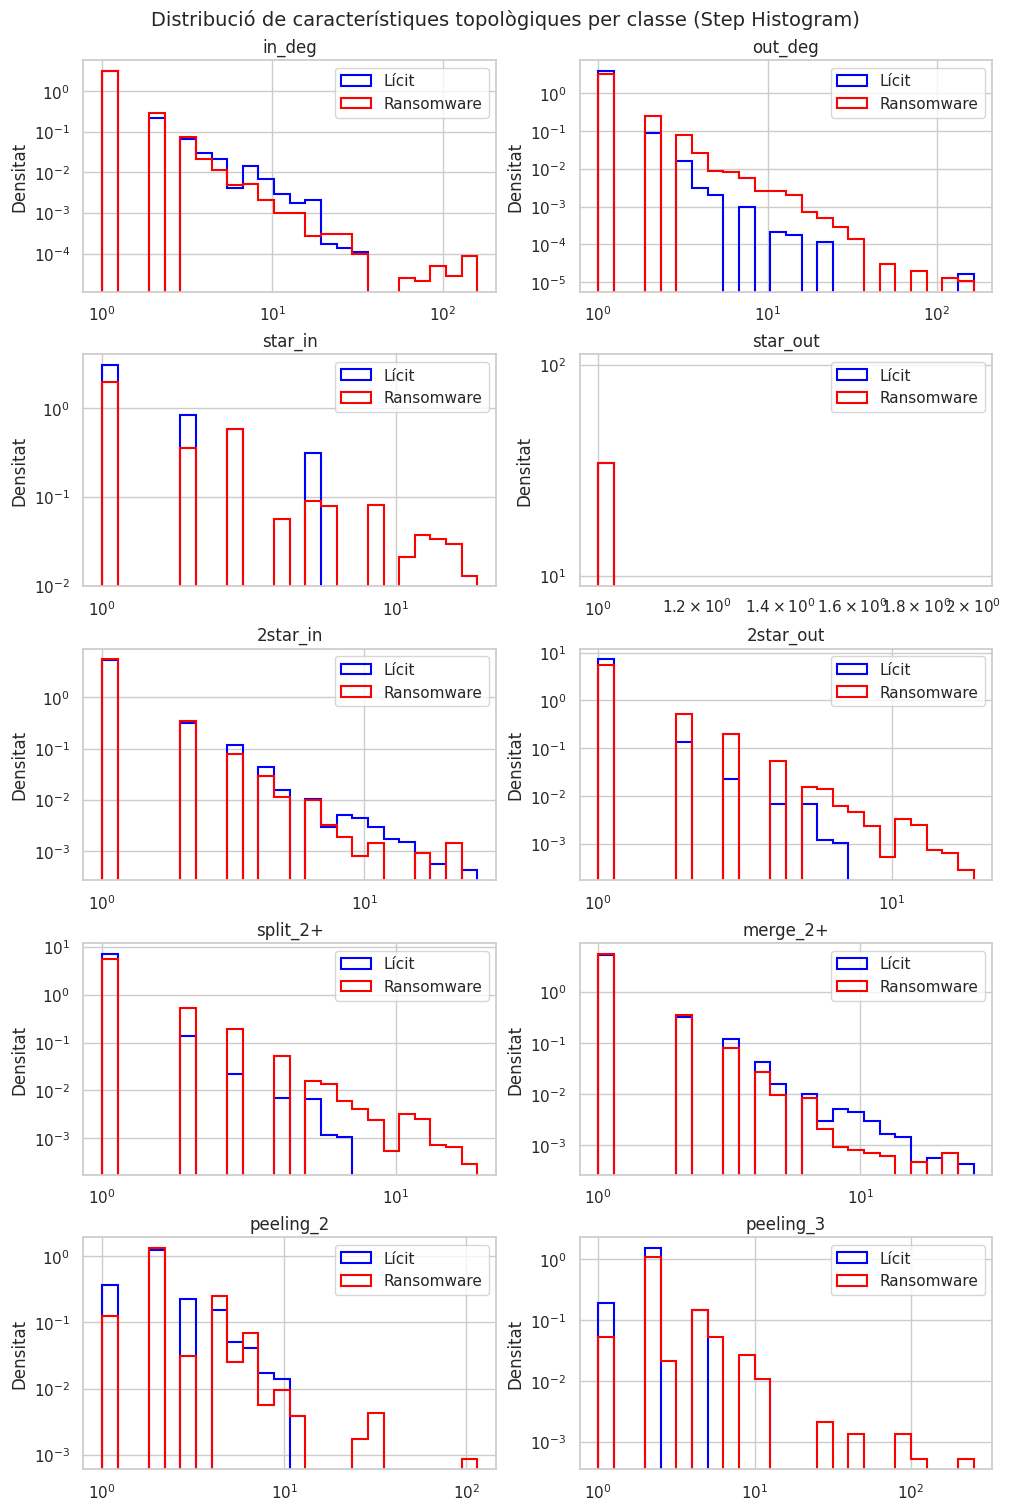

In [36]:
features = ['in_deg', 'out_deg', 'star_in', 'star_out', '2star_in', '2star_out', 'split_2+', 'merge_2+', 'peeling_2', 'peeling_3']

n_cols = 2
n_rows = int(np.ceil(len(features) / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 3), constrained_layout=True)

for i, feature in enumerate(features):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col] if n_rows > 1 else axs[col]

    # Separar les dues classes
    licit_values = df[df['label'] == 0][feature]
    illicit_values = df[df['label'] == 1][feature]

    # Definir els bins (escala logarítmica)
    max_val = max(df[feature].max(), 1)
    bins = np.logspace(0, np.log10(max_val + 1), 25)  # Ajusta el nombre de bins si cal

    # Step histogram per evitar solapament
    ax.hist(licit_values, bins=bins, histtype='step', color='blue', label='Lícit', density=True, linewidth=1.5)
    ax.hist(illicit_values, bins=bins, histtype='step', color='red', label='Ransomware', density=True, linewidth=1.5)

    ax.set_xscale('log')
    ax.set_title(feature)
    ax.set_ylabel('Densitat')
    ax.set_yscale('log')
    ax.legend()

fig.suptitle('Distribució de característiques topològiques per classe (Step Histogram)', fontsize=14)
plt.show()

,feature,chi2,chi2_p,MI
8,in_deg,1809.305540,0.000000e+00,0.238469
9,out_deg,1501.780205,0.000000e+00,0.169518
4,split_2+,484.484451,2.259157e-107,0.029450
3,2star_out,492.058402,5.080767e-109,0.025607
7,peeling_3,919.417582,5.898224e-202,0.016479
5,merge_2+,14.515982,1.389755e-04,0.012341
2,2star_in,29.048976,7.057138e-08,0.004619
6,peeling_2,405.306533,3.852902e-90,0.003174
0,star_in,167.704225,2.347503e-38,0.000000
1,star_out,8.066667,4.508698e-03,0.000000


Features seleccionades: ['star_in', '2star_in', '2star_out', 'split_2+', 'merge_2+', 'peeling_2', 'peeling_3', 'in_deg', 'out_deg']


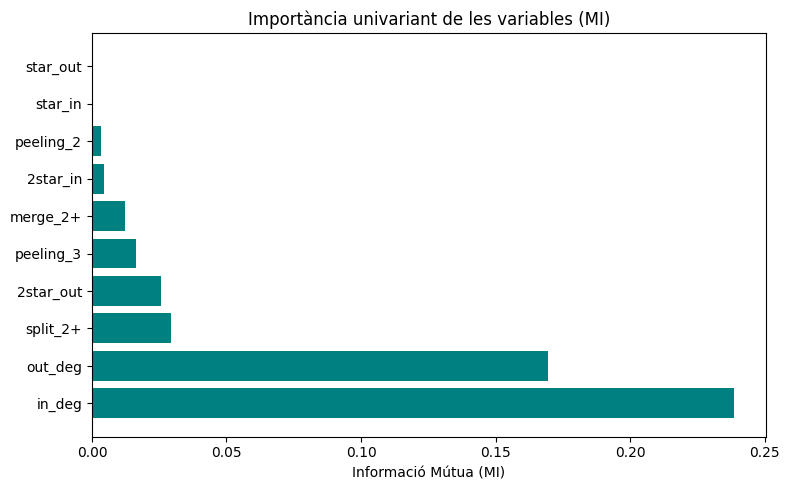

In [4]:
# # 2. Selecció univariant (χ² + MI)

# %%
# χ² requereix valors no negatius; fem un min-max a [0,1]
X_pos = X - X.min(axis=0)
chi2_scores, chi2_p = chi2(X_pos, y)

mi_scores = mutual_info_classif(X, y, random_state=RANDOM_STATE)

univariate = pd.DataFrame({
    'feature': feature_names,
    'chi2': chi2_scores,
    'chi2_p': chi2_p,
    'MI': mi_scores
}).sort_values('MI', ascending=False)

display(univariate.head(10))

# Retain the top 90 % highest MI+χ² features (discard bottom 10 %)

selector = SelectPercentile(mutual_info_classif, percentile=90)
X_sel = selector.fit_transform(X, y)
sel_features = [f for f, keep in zip(feature_names, selector.get_support()) if keep]
print("Features seleccionades:", sel_features)


# Ordenar per MI
univariate_sorted = univariate.sort_values('MI', ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(univariate_sorted['feature'], univariate_sorted['MI'], color='teal')
plt.xlabel('Informació Mútua (MI)')
plt.title('Importància univariant de les variables (MI)')
plt.tight_layout()
plt.show()


In [5]:
# # 3. Model lineal amb penalització L1

# %%
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sel)

logreg = LogisticRegression(
    penalty='l1', solver='saga', max_iter = 8000, C=0.3,warm_start=True,
    class_weight='balanced', random_state=RANDOM_STATE
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(logreg, X_scaled, y, cv=cv, scoring='roc_auc')
print("ROC-AUC mitjana (5-fold):", scores.mean().round(3))

# entrenem per obtenir coeficients
logreg.fit(X_scaled, y)
coef = pd.Series(logreg.coef_[0], index=sel_features).sort_values()
display(coef)

# ## 3.1 Odds ratio
odds = np.exp(coef)
odds.to_frame('odds_ratio').sort_values('odds_ratio', ascending=False).head(10)

ROC-AUC mitjana (5-fold): 0.851


star_in     -0.621136
merge_2+    -0.422123
2star_in    -0.291678
split_2+    -0.026734
peeling_2   -0.014531
2star_out   -0.012698
peeling_3    0.767552
in_deg       4.000752
out_deg      4.792454
dtype: float64

,odds_ratio
out_deg,120.596895
in_deg,54.639208
peeling_3,2.154485
2star_out,0.987382
peeling_2,0.985574
split_2+,0.973620
2star_in,0.747009
merge_2+,0.655653
star_in,0.537334


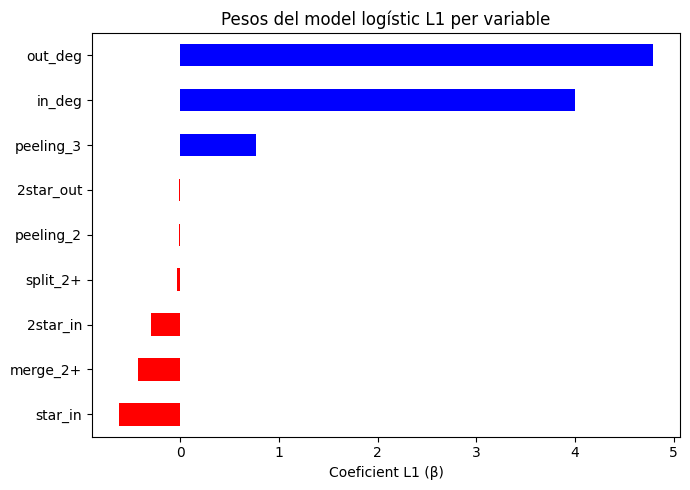

In [6]:
plt.figure(figsize=(7, 5))
coef.plot(kind='barh', color=['red' if c < 0 else 'blue' for c in coef])
plt.xlabel('Coeficient L1 (β)')
plt.title('Pesos del model logístic L1 per variable')
plt.tight_layout()
plt.show()

In [7]:
# %% [6] Bootstrap CI95 % dels coeficients
from tqdm import tqdm
B = 200

boot = np.zeros((B, len(sel_features)))
for b in tqdm(range(B)):
    idx = np.random.choice(len(y), len(y), replace=True)
    logreg.fit(X_scaled[idx], y[idx])
    boot[b] = logreg.coef_[0]
ci_low, ci_high = np.percentile(boot, [2.5,97.5], axis=0)

tab_coef = (
    pd.Series(logreg.coef_[0], index=sel_features, name='coef')
      .to_frame()
      .assign(ci_low=ci_low, ci_high=ci_high)
      .sort_values('coef')
)
print(tab_coef)


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [08:08<00:00,  2.44s/it]

               coef    ci_low   ci_high
star_in   -1.085021 -1.265029  0.000000
merge_2+  -0.716153 -0.881269 -0.500506
split_2+  -0.222878 -0.282580  0.222707
2star_out -0.201131 -0.259312  0.257803
peeling_2 -0.117418 -0.382876  0.000000
2star_in   0.000000 -0.131535  0.000000
peeling_3  1.308554  0.576943  1.576008
in_deg     5.061330  2.894708  5.745841
out_deg    7.893667  1.156294  9.696615


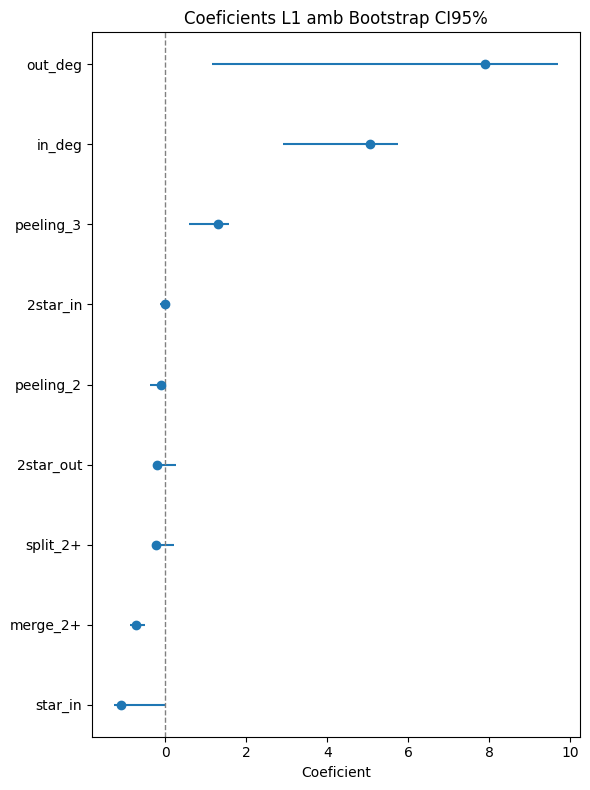

In [8]:
tab_coef = tab_coef.sort_values('coef')  # Ordenar pel valor central

plt.figure(figsize=(6, 8))
plt.errorbar(
    x=tab_coef['coef'],
    y=tab_coef.index,
    xerr=[tab_coef['coef'] - tab_coef['ci_low'], tab_coef['ci_high'] - tab_coef['coef']],
    fmt='o'
)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
plt.title('Coeficients L1 +- CI95%')
plt.xlabel('Coeficient')
plt.tight_layout()
plt.show()

In [9]:
# %% [7] Permutation Importance (variance explained proxy)
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE)
rf.fit(X_sel, y)
pi = permutation_importance(rf, X_sel, y, n_repeats=20, random_state=RANDOM_STATE)
pi_df = pd.DataFrame({'feature': sel_features, 'perm_import': pi.importances_mean})\
        .sort_values('perm_import', ascending=False)
pi_df.to_csv(RES_DIR/f'permutation_importance_{RADIUS}.csv', index=False)
print(pi_df)

     feature  perm_import
7     in_deg     0.324189
8    out_deg     0.230336
5  peeling_2     0.005487
6  peeling_3     0.004466
2  2star_out     0.003321
4   merge_2+     0.003061
3   split_2+     0.002944
1   2star_in     0.002927
0    star_in     0.001138


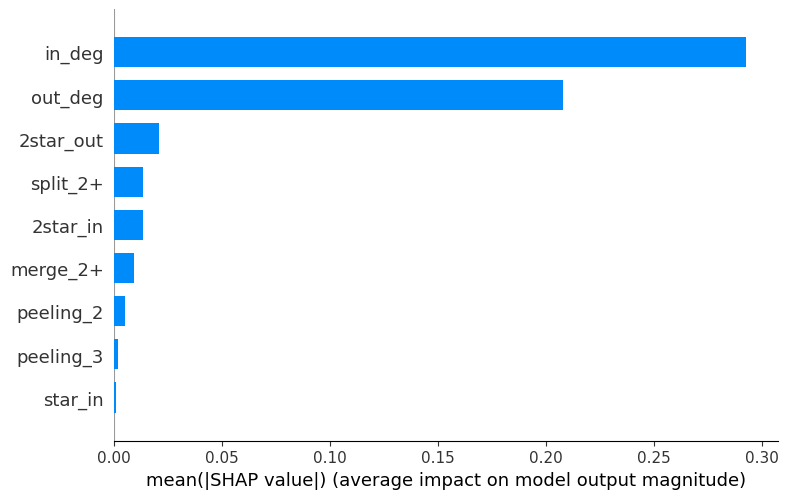

In [10]:
# %% [8] SHAP bar
explainer = shap.TreeExplainer(rf)
shap_vals = explainer.shap_values(X_sel)
shap.summary_plot(shap_vals[1], X_sel, feature_names=sel_features, plot_type='bar', show=False)
plt.savefig(RES_DIR / f'shap_bar_{RADIUS}.png', dpi=300, bbox_inches='tight')


In [11]:
print(tab_coef.columns)      # veure quins noms té
print(tab_coef.index[:5])    # si els noms de variable són a l’índex

Index(['coef', 'ci_low', 'ci_high'], dtype='object')
Index(['star_in', 'merge_2+', 'split_2+', '2star_out', 'peeling_2'], dtype='object')


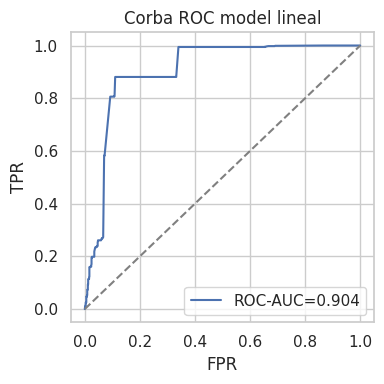

In [43]:
"""# %% [9] Figures addicionals
# Coef L1 ± CI
tab_coef = tab_coef.reset_index().rename(columns={'index': 'feature'})
plt.figure(figsize=(6,4))
plt.errorbar(tab_coef['coef'], tab_coef['feature'],
             xerr=[tab_coef['coef']-tab_coef['ci_low'], tab_coef['ci_high']-tab_coef['coef']],
             fmt='o')
plt.axvline(0, color='k', lw=0.8)
plt.title('Coeficients L1 ± CI95 %')
plt.tight_layout(); plt.savefig(RES_DIR / 'coef_L1.png', dpi=300)

# Permutation Importance
plt.figure(figsize=(6,4))
pi_df.head(15).plot.barh(x='feature', y='perm_import', legend=False)
plt.title('Permutation Importance')
plt.tight_layout(); plt.savefig(RES_DIR / 'pi_metapaths.png', dpi=300)"""

# Curva ROC final test/val
X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
logreg.fit(X_tr, y_tr)
y_prob = logreg.predict_proba(X_te)[:,1]
fpr, tpr, _ = roc_curve(y_te, y_prob)
plt.figure(figsize=(4,4))
plt.title('Corba ROC model lineal')
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc_score(y_te, y_prob):.3f}")
plt.plot([0,1],[0,1],'--',color='gray'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.tight_layout()
plt.savefig(RES_DIR / 'roc_metapaths.png', dpi=300)
# %% EOF


    Variable  Lícit Mitjana  Lícit SD  Il·lícit Mitjana  Il·lícit SD
0    star_in       0.004015  0.115632          0.067247     0.828598
1   star_out       0.000669  0.025863          0.004349     0.065817
2   2star_in       0.371696  1.182770          0.461693     1.217188
3  2star_out       0.421211  0.600840          0.884911     1.474959
4   split_2+       0.421211  0.600840          0.880562     1.468359
5   merge_2+       0.371696  1.182770          0.434259     1.039760
6  peeling_2       0.038140  0.398983          0.228170     3.149998
7  peeling_3       0.015055  0.193885          0.350284     6.853512
8     in_deg       0.859485  2.026183          2.226163     9.155600
9    out_deg       0.748076  3.097441          1.901974     4.471024


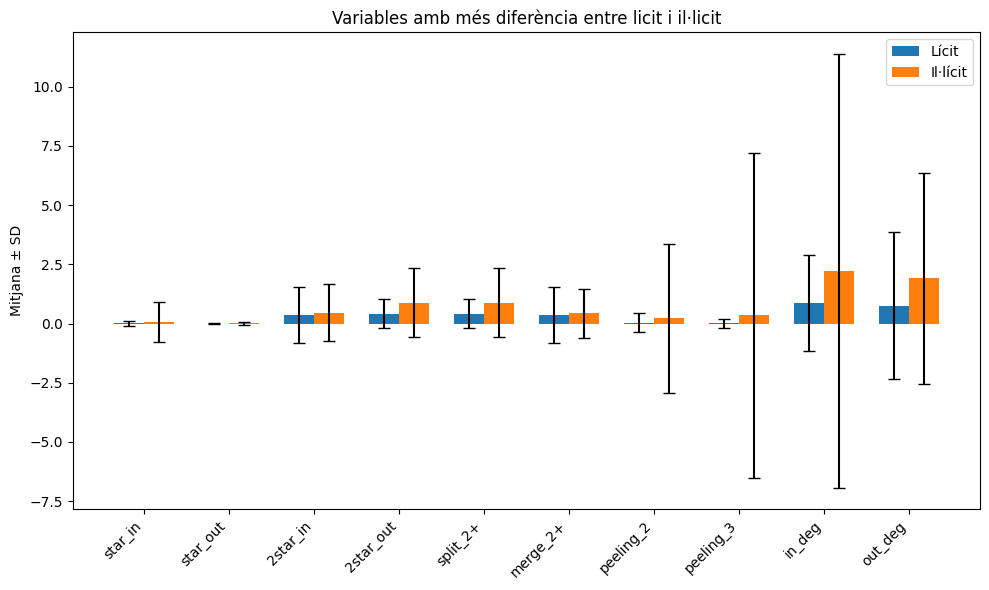

In [14]:
label_map = {0: 'Lícit', 1: 'Il·lícit'}

# Llista de variables a descriure
features = [
    'star_in', 'star_out', '2star_in', '2star_out',
    'split_2+', 'merge_2+', 'peeling_2', 'peeling_3',
    'in_deg', 'out_deg'
]

# Agrupar per label i calcular mitjana i desviació estàndard
grouped = df.groupby('label')[features].agg(['mean', 'std'])

# Reindexar columnes per tenir un format pla: ('Variable', 'Lícit mean', 'Lícit std', 'Il·lícit mean', 'Il·lícit std')
df_stats = pd.DataFrame()
df_stats['Variable'] = features
for lbl in [0, 1]:
    df_stats[f"{label_map[lbl]} Mitjana"] = grouped.loc[lbl, (slice(None), 'mean')].values
    df_stats[f"{label_map[lbl]} SD"]      = grouped.loc[lbl, (slice(None), 'std')].values

# Mostra la taula
print(df_stats)


# Configuració de l’eix
x = np.arange(len(df_stats))
amplada = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - amplada/2, df_stats['Lícit Mitjana'], amplada,
        yerr=df_stats['Lícit SD'], capsize=4, label='Lícit')
plt.bar(x + amplada/2, df_stats['Il·lícit Mitjana'], amplada,
        yerr=df_stats['Il·lícit SD'], capsize=4, label='Il·lícit')

plt.xticks(x, df_stats['Variable'], rotation=45, ha='right')
plt.ylabel('Mitjana ± SD')
plt.title('Variables amb més diferència entre licit i il·licit')
plt.legend()
plt.tight_layout()
plt.show()

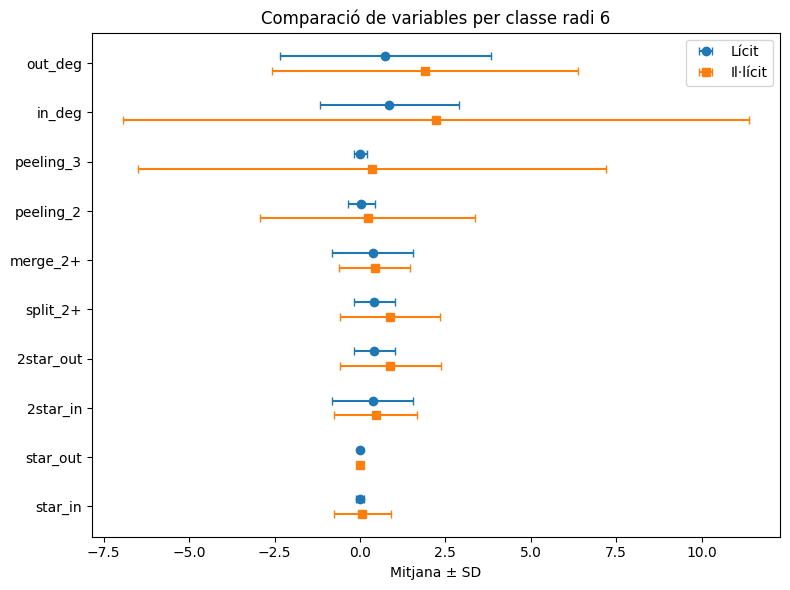

In [22]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import mannwhitneyu, iqr
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from tqdm import tqdm
import shap

sns.set_theme(style="whitegrid")
RANDOM_STATE = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ---------------------------------------------------------------
# 1. TAULA DESCRIPTIVA + p-values
# ---------------------------------------------------------------
rows = []
for feat in sel_features:
    licit   = df.loc[df.label == 0, feat]
    illicit = df.loc[df.label == 1, feat]
    u, p = mannwhitneyu(licit, illicit, alternative='two-sided')
    rows.append({
        "feature": feat,
        "median_licit":   np.median(licit),  "IQR_licit":   iqr(licit),
        "median_illicit": np.median(illicit), "IQR_illicit": iqr(illicit),
        "p_MannWhitney":  p
    })

desc_df = (pd.DataFrame(rows)
             .sort_values("p_MannWhitney")
             .reset_index(drop=True))
print("\n=== Descriptiva + Mann-Whitney ===")
print(desc_df.head(15).to_string(index=False))


=== Descriptiva + Mann-Whitney ===
   feature  median_licit  IQR_licit  median_illicit  IQR_illicit  p_MannWhitney
    in_deg           0.0        1.0             1.0          0.0   0.000000e+00
   out_deg           1.0        1.0             1.0          0.0   0.000000e+00
 2star_out           0.0        1.0             1.0          1.0   9.525500e-48
  split_2+           0.0        1.0             1.0          1.0   2.896224e-47
  2star_in           0.0        0.0             0.0          1.0   1.796238e-13
  merge_2+           0.0        0.0             0.0          1.0   8.456754e-13
 peeling_2           0.0        0.0             0.0          0.0   6.869776e-10
 peeling_3           0.0        0.0             0.0          0.0   2.781665e-08
   star_in           0.0        0.0             0.0          0.0   1.914711e-06


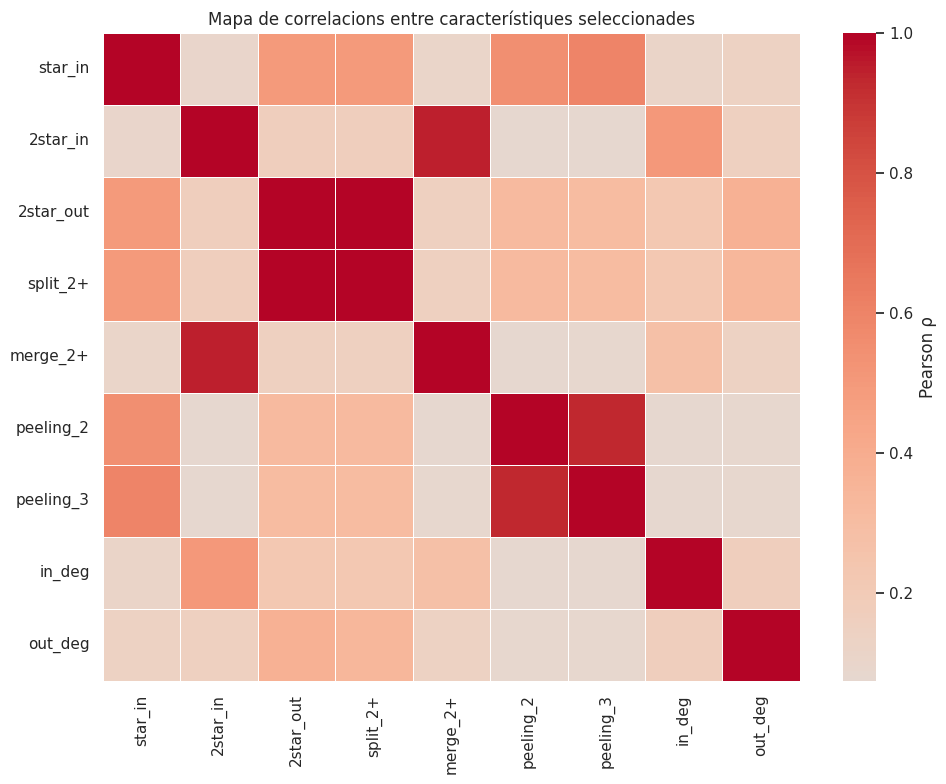

In [23]:
corr = pd.DataFrame(X_sel, columns=sel_features).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidth=.5,
            cbar_kws=dict(label="Pearson ρ"))
plt.title("Mapa de correlacions entre característiques seleccionades")
plt.tight_layout()
plt.show()

In [24]:
print("\n=== Precision–Recall global ===")
y_scores = cross_val_score(
    logreg, X_scaled, y, cv=cv,
    scoring="roc_auc"  # ja el tens; generem ara PR
)  # només per mostrar que l'AUC ROC existeix
y_cv_prob = np.zeros_like(y, dtype=float)
for train_idx, test_idx in cv.split(X_scaled, y):
    logreg.fit(X_scaled[train_idx], y[train_idx])
    y_cv_prob[test_idx] = logreg.predict_proba(X_scaled[test_idx])[:,1]

prec, rec, _ = precision_recall_curve(y, y_cv_prob)
ap  = average_precision_score(y, y_cv_prob)
plt.figure(figsize=(5,4))
plt.step(rec, prec, where="post")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.tight_layout(); plt.show()


=== Precision–Recall global ===


ValueError: Found input variables with inconsistent numbers of samples: [5978, 10]

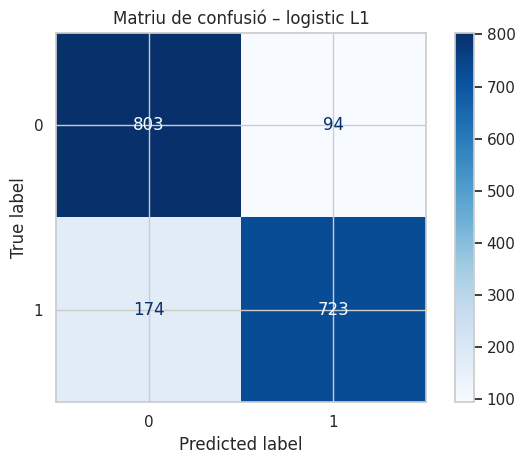


=== Classification report (hold-out 30 %) ===
              precision    recall  f1-score   support

           0      0.822     0.895     0.857       897
           1      0.885     0.806     0.844       897

    accuracy                          0.851      1794
   macro avg      0.853     0.851     0.850      1794
weighted avg      0.853     0.851     0.850      1794



In [26]:
y_pred  = logreg.predict(X_te)
cm      = confusion_matrix(y_te, y_pred)
disp    = ConfusionMatrixDisplay(cm)
disp.plot(values_format='d', cmap="Blues")
plt.title("Matriu de confusió – logistic L1")
plt.tight_layout(); plt.show()

print("\n=== Classification report (hold-out 30 %) ===")
print(classification_report(y_te, y_pred, digits=3))

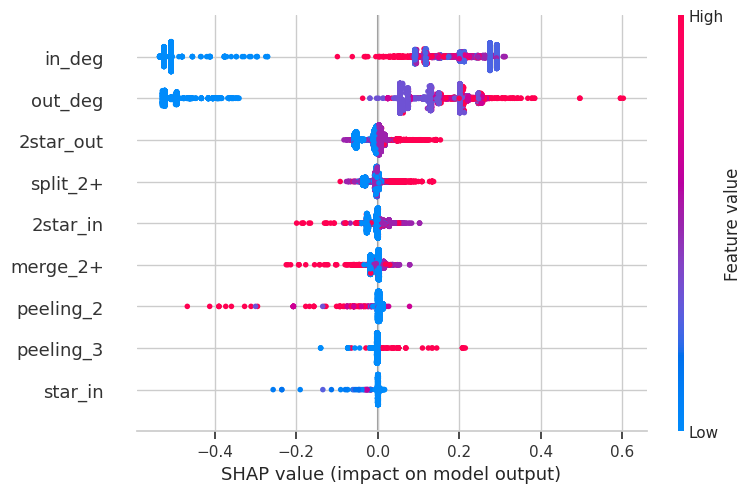

In [27]:
plt.figure()  # per evitar que el barplot se sobreescrigui
shap.summary_plot(
    shap_vals[1], X_sel, feature_names=sel_features,
    plot_type="dot", show=True
)

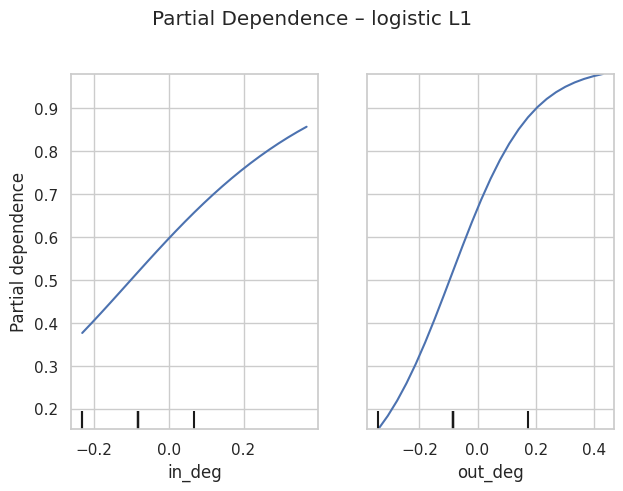

In [28]:
base_features = ['in_deg', 'out_deg']
idx = [sel_features.index(f) for f in base_features]
PartialDependenceDisplay.from_estimator(
    logreg, X_scaled, features=idx,
    feature_names=sel_features, kind="average", grid_resolution=25,
    n_jobs=-1
)
plt.suptitle("Partial Dependence – logistic L1", y=1.02)
plt.tight_layout(); plt.show()

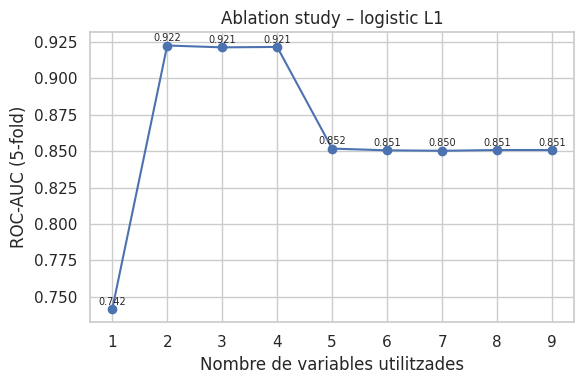


=== Ablation AUC per #variables ===
 1 vars -> AUC 0.742
 2 vars -> AUC 0.922
 3 vars -> AUC 0.921
 4 vars -> AUC 0.921
 5 vars -> AUC 0.852
 6 vars -> AUC 0.851
 7 vars -> AUC 0.850
 8 vars -> AUC 0.851
 9 vars -> AUC 0.851


In [33]:
ordered = (np.abs(logreg.coef_[0])
           .argsort()[::-1])  # de més a menys pes
ordered_feats = [sel_features[i] for i in ordered]

auc_list = []
for k in range(1, len(ordered_feats) + 1):
    subset = ordered_feats[:k]
    idxs   = [sel_features.index(f) for f in subset]
    
    # ---- FIX ----
    if hasattr(X_scaled, "iloc"):          # DataFrame
        X_sub = X_scaled.iloc[:, idxs].values
    else:                                  # ndarray
        X_sub = X_scaled[:, idxs]
    # -------------    

    auc_k = cross_val_score(
        logreg, X_sub, y, cv=cv, scoring="roc_auc",
        n_jobs=-1
    ).mean()
    auc_list.append(auc_k)


plt.figure(figsize=(6,4))
plt.plot(range(1, len(auc_list)+1), auc_list, marker='o')
plt.xlabel('Nombre de variables utilitzades')
plt.ylabel('ROC-AUC (5-fold)')
plt.title('Ablation study – logistic L1')
for i, v in enumerate(auc_list, 1):
    plt.text(i, v+0.003, f"{v:.3f}", ha='center', fontsize=7)
plt.tight_layout(); plt.show()

print("\n=== Ablation AUC per #variables ===")
for k, auc_k in enumerate(auc_list, 1):
    print(f"{k:2d} vars -> AUC {auc_k:.3f}")

In [31]:
print("X_sub shape:", X_sub.shape)
print("len(y):", len(y))

X_sub shape: (5978, 1)
len(y): 10


In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
def evaluate_models(X_train, X_test, y_train, y_test, logreg, rf):
    """
    Avalua dos models (regressió logística i Random Forest) sobre el mateix conjunt de test.
    Retorna un DataFrame resum amb les mètriques clau per a cada model.
    """
    results = []
    for name, model in [("LogisticRegression", logreg), ("RandomForest", rf)]:
        # Prediccions
        y_pred = model.predict(X_test)
        # Probabilitats positives (per ROC‑AUC)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_prob)
        else:
            y_prob = None
            roc_auc = None
        
        # Càlcul de mètriques
        acc    = accuracy_score(y_test, y_pred)
        prec   = precision_score(y_test, y_pred)
        rec    = recall_score(y_test, y_pred)
        f1     = f1_score(y_test, y_pred)
        
        results.append({
            "model": name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "roc_auc": roc_auc
        })
    
    return pd.DataFrame(results).set_index("model")
metrics_df = evaluate_models(X_tr, X_te, y_tr, y_te, logreg, rf)
display(metrics_df)

,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
LogisticRegression,0.850613,0.884945,0.806020,0.843641,0.904356
RandomForest,0.511706,0.956522,0.024526,0.047826,0.485868


In [ ]:

accuracy	precision	recall	f1_score	roc_auc
model					
LogisticRegression	0.850613	0.884945	0.806020	0.843641	0.904356
RandomForest	0.711706	0.956522	0.824526	0.787826	0.885868
